In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import torch
import os

/ext3/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LabelDataset(tf.data.Dataset):
    def __init__(self, path, batch_size):
        self.video_paths = [os.path.join(path, dir_path) for dir_path in os.listdir(path) if dir_path.startswith('video')]
        self.num_samples = 0

        # Load the mask shape from the first video path
        mask_sample_path = os.path.join(self.video_paths[0], 'mask.npy')
        mask_shapes = np.load(mask_sample_path).shape

        # Calculate the total number of samples
        self.num_samples = mask_shapes[0] * len(self.video_paths)
        self.batch_size = batch_size

    def _inputs(self):
        return []

    def element_spec(self):
        image_shape = tf.TensorShape([None, None, 3])
        mask_shape = tf.TensorShape([None])
        return (image_shape, mask_shape)

    def _generator(self):
        images_batch = []
        masks_batch = []
        for path in self.video_paths:
            mask_path = os.path.join(path, 'mask.npy')
            masks = np.load(mask_path)

            for i in range(masks.shape[0]): 
                image_path = os.path.join(path, f'image_{i}.png')
                image_data = tf.io.read_file(image_path)

                image = tf.image.decode_png(image_data, channels=3)
                #normalize
                image = tf.cast(image, tf.float32)
                image = ((image / 255.0) - 0.5) * 2.0  # Rescale to [-1, 1].
                image = tf.image.resize(
                    image, (160,240), method=tf.image.ResizeMethod.BILINEAR)
                image = tf.clip_by_value(image, -1., 1.)
                
                mask = tf.convert_to_tensor(masks[i])

                images_batch.append(image)
                masks_batch.append(mask)

                if ((len(images_batch) >= self.batch_size) & (len(masks_batch) >= self.batch_size)):
                    output_images_batch = images_batch[:]
                    output_masks_batch = masks_batch[:]

                    images_batch = []
                    masks_batch = []

                    yield {'image': tf.stack(output_images_batch), 'target': tf.stack(output_masks_batch)}

    def __len__(self):
        return self.num_samples

    def __iter__(self):
        return self._generator()

In [3]:
path = 'dataset/train/'
custom_dataset = LabelDataset(path, 10).__iter__()

In [4]:
unique_values_1 = set()
unique_values_2 = set()

unique_image_set_1 = []
unique_image_set_2 = []
unique_target_set_1 = []
unique_target_set_2 = []


for data in  custom_dataset:
    for vector_indices in range(data['target'].shape[0]):
        target_unique = set(np.unique(data['target'][vector_indices].numpy()))
        if target_unique - unique_values_1:
            unique_values_1 = unique_values_1.union(target_unique)
            unique_image_set_1.append(data['image'][vector_indices])
            unique_target_set_1.append(data['target'][vector_indices])
            
        elif target_unique - unique_values_2:
            unique_values_2 = unique_values_2.union(target_unique)
            unique_image_set_2.append(data['image'][vector_indices])
            unique_target_set_2.append(data['target'][vector_indices])

2024-04-19 03:20:45.229540: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def visualize_batch_segments(target, image):
    unique_batches = np.unique(target.numpy())
    num_unique_batches = len(unique_batches)
    
    fig, axes = plt.subplots(1, num_unique_batches, figsize=(5*num_unique_batches, 5))
    axes[0].imshow(tf.cast((image + 1) * (255 / 2), tf.uint8))
    axes[0].set_title(f"Image")
    
    for batch_num in range(1, num_unique_batches):
        # Create a mask for the current batch
        batch_mask = tf.cast(target == unique_batches[batch_num], tf.float32)
        
        # Apply the mask to the image
        masked_image = tf.cast(image, tf.float32) * tf.expand_dims(batch_mask, axis=-1)
        
        # Plot the masked image and the mask itself
        axes[batch_num].imshow(tf.cast((masked_image + 1) * (255 / 2), tf.uint8))
        axes[batch_num].set_title(f"Code {unique_batches[batch_num]} in Image")
        #axes[2].imshow(batch_mask, cmap='gray')
        #axes[2].set_title(f"Segment {batch_num} Mask")
    plt.show()

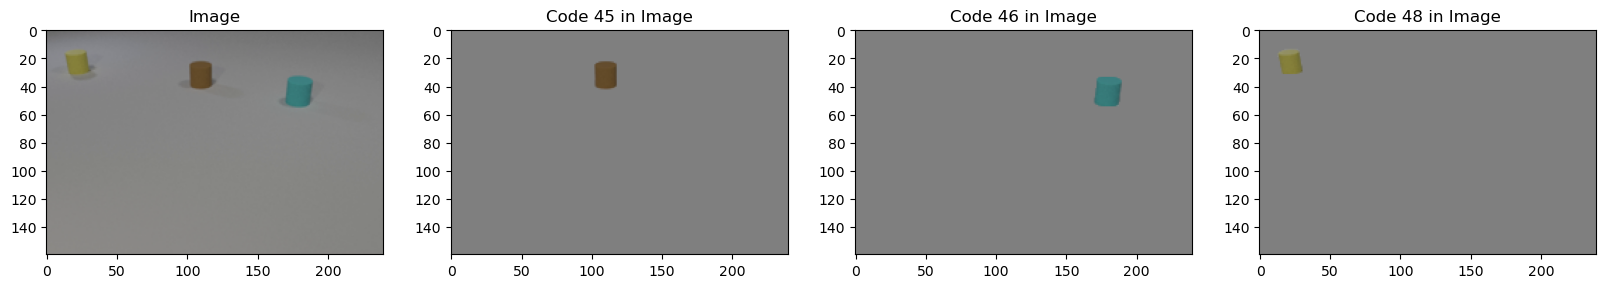

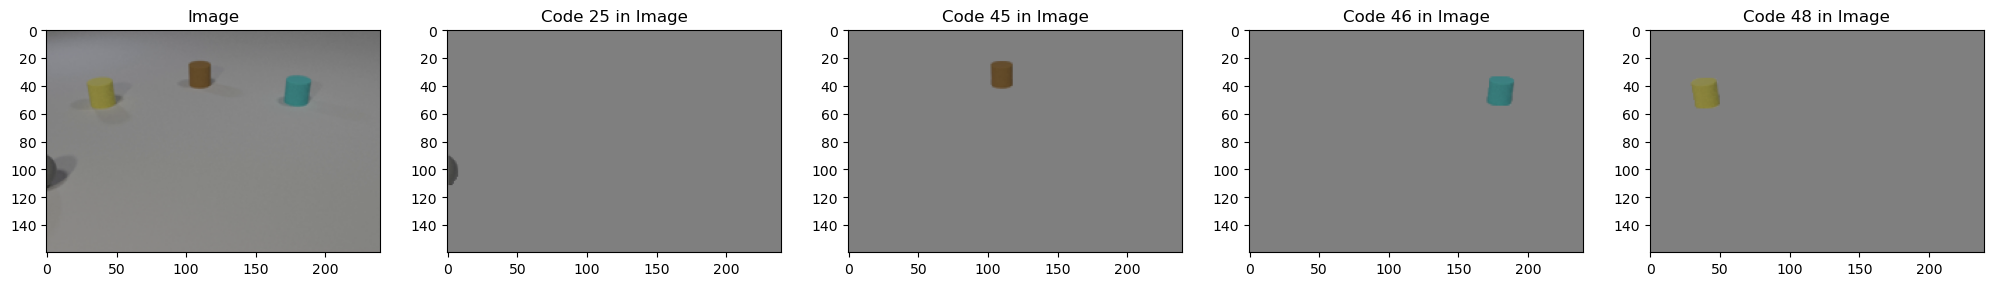

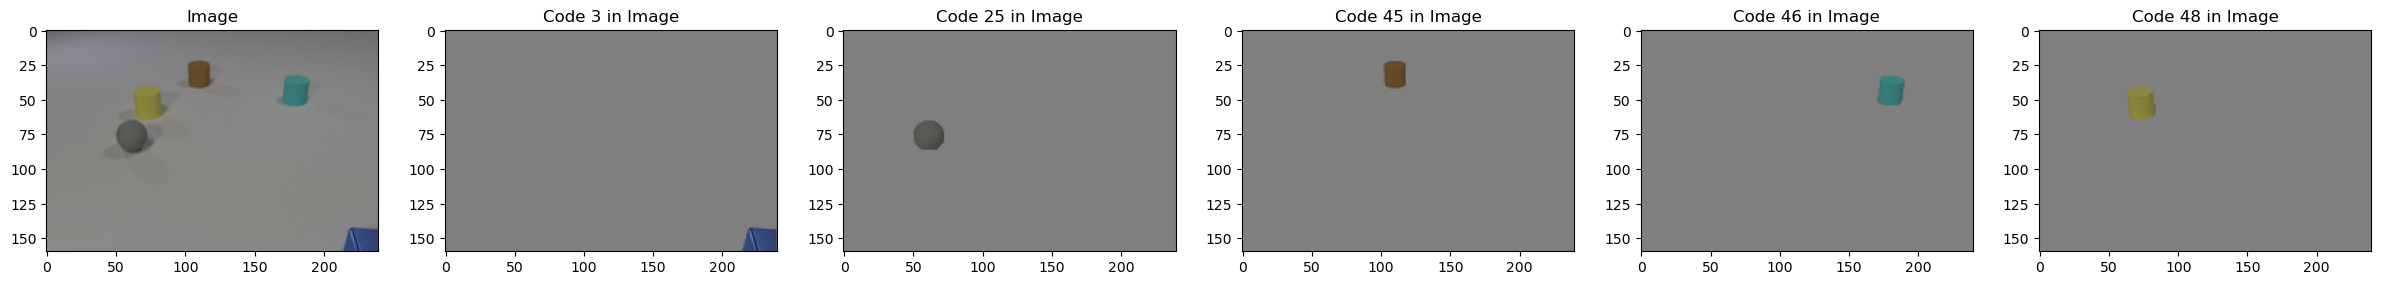

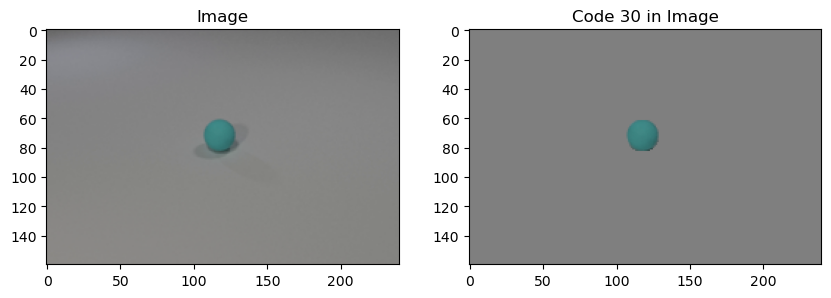

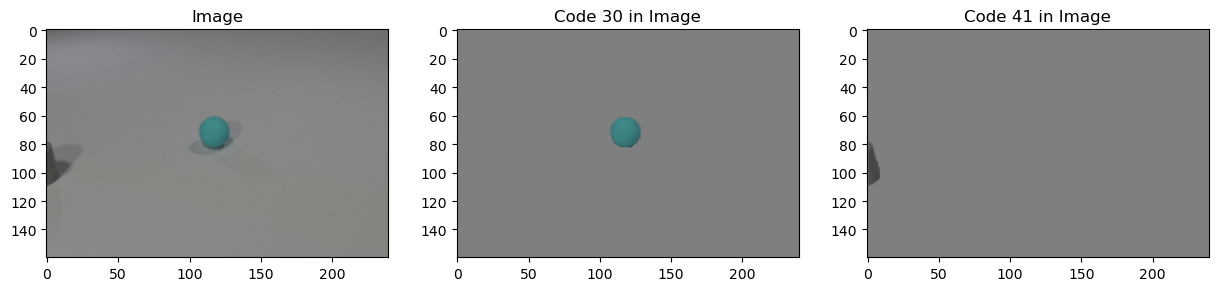

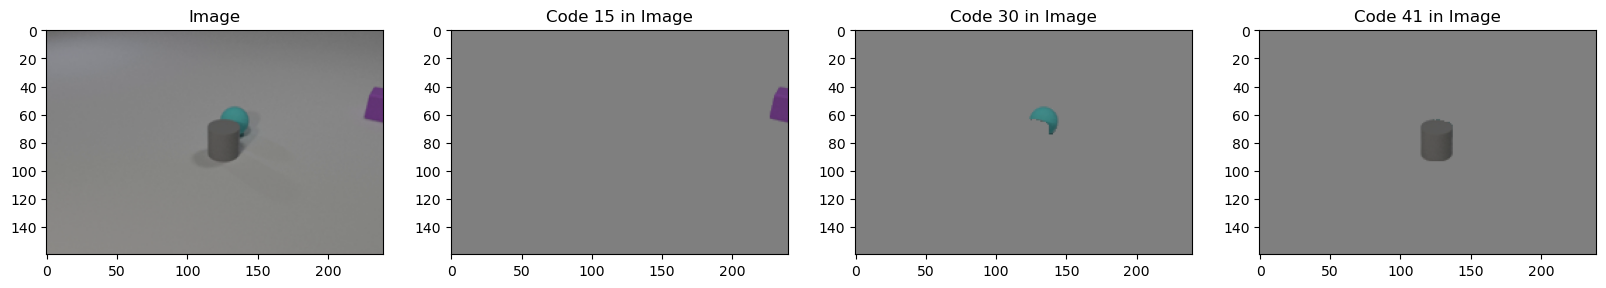

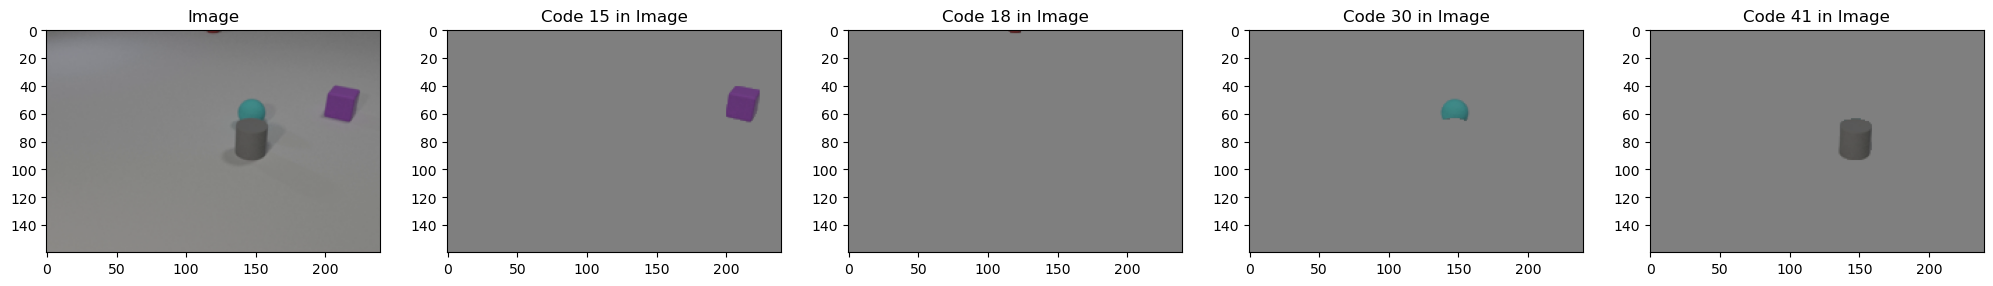

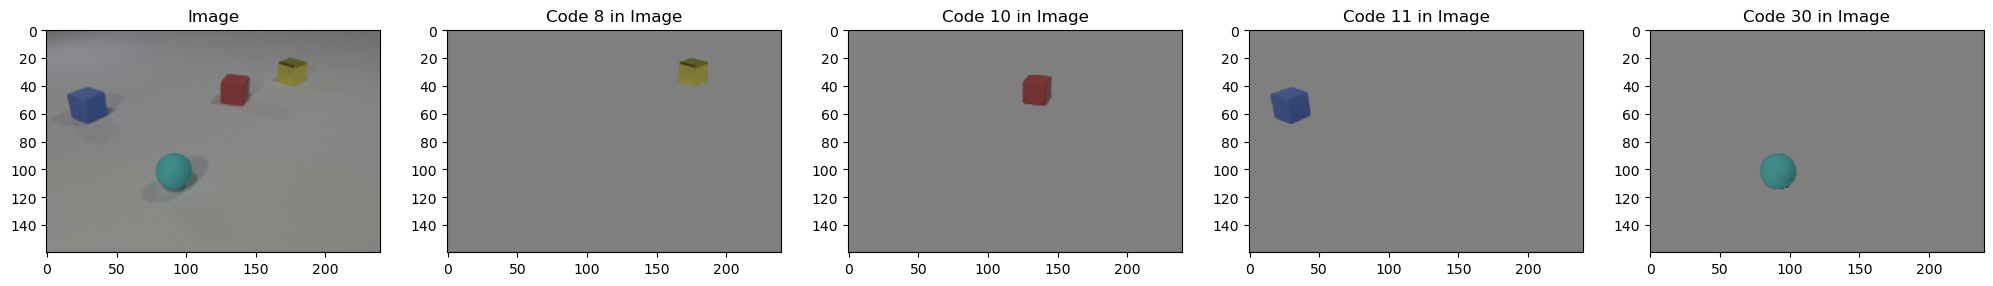

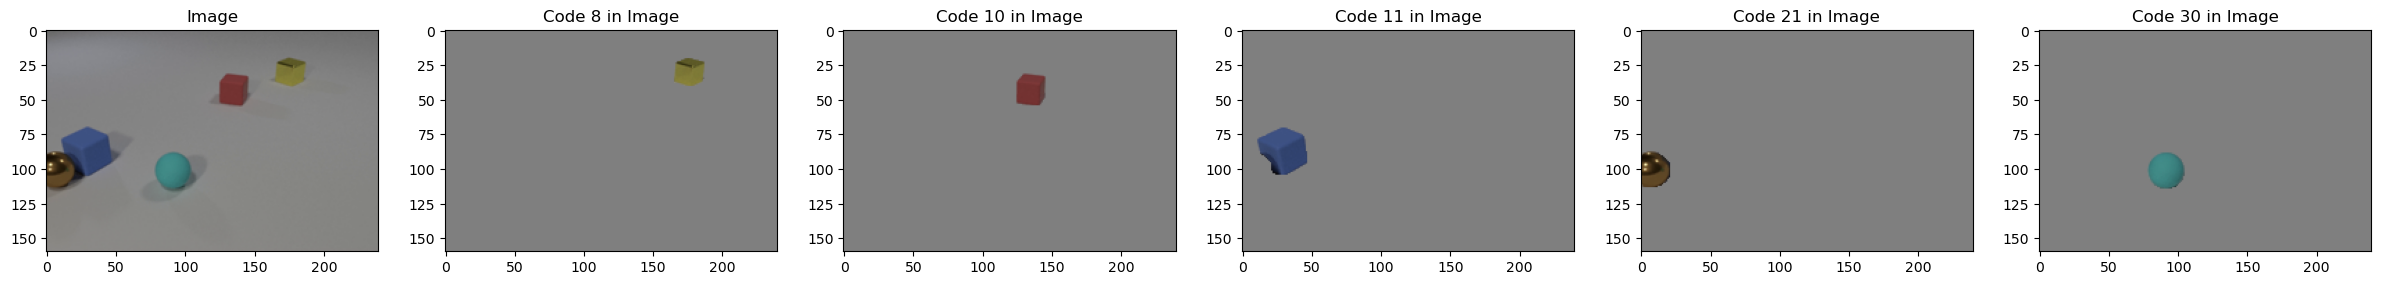

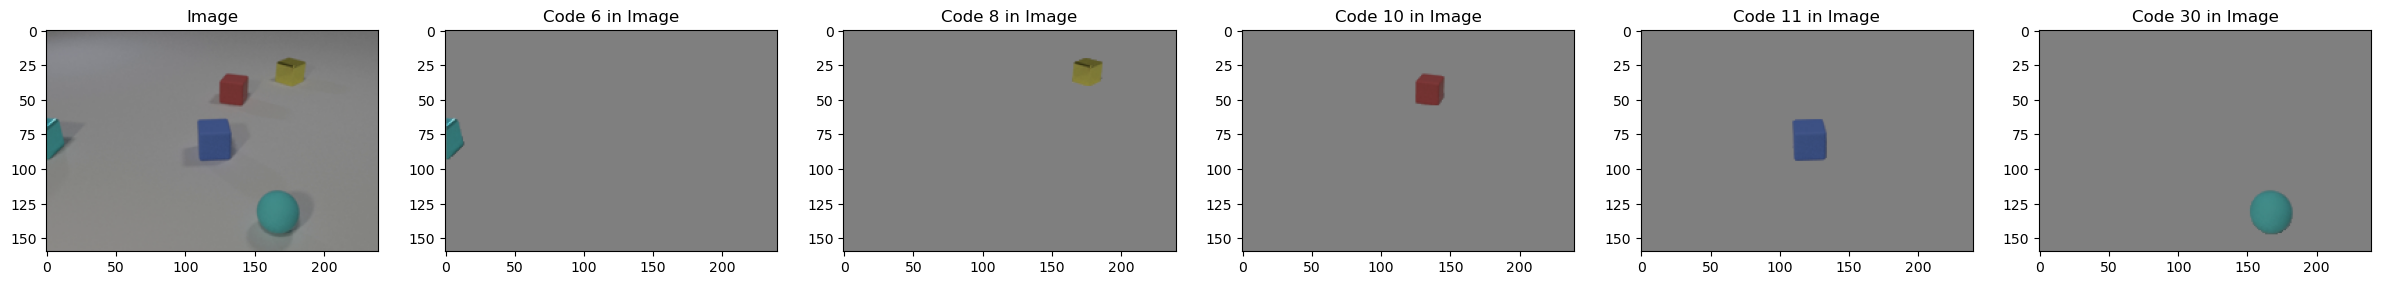

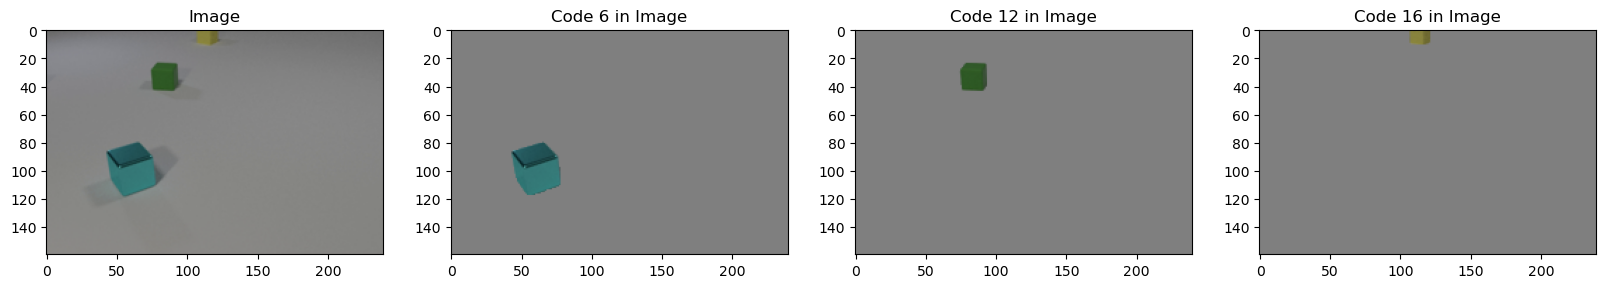

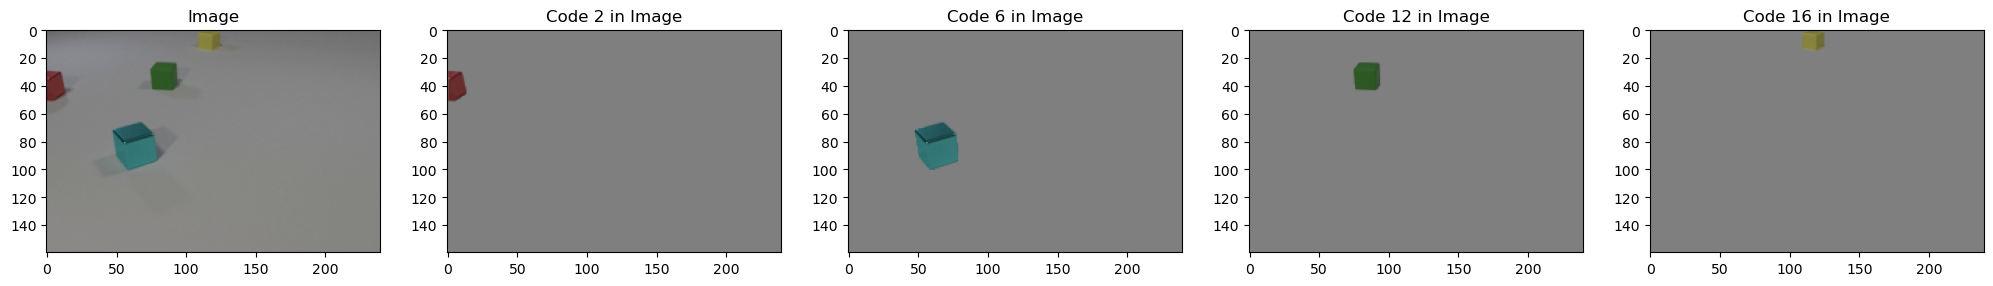

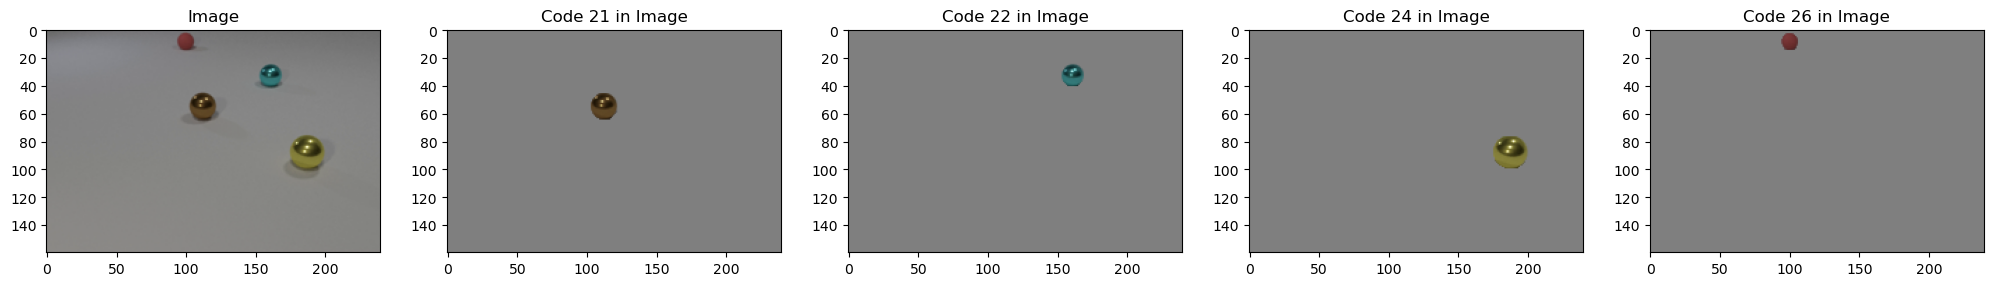

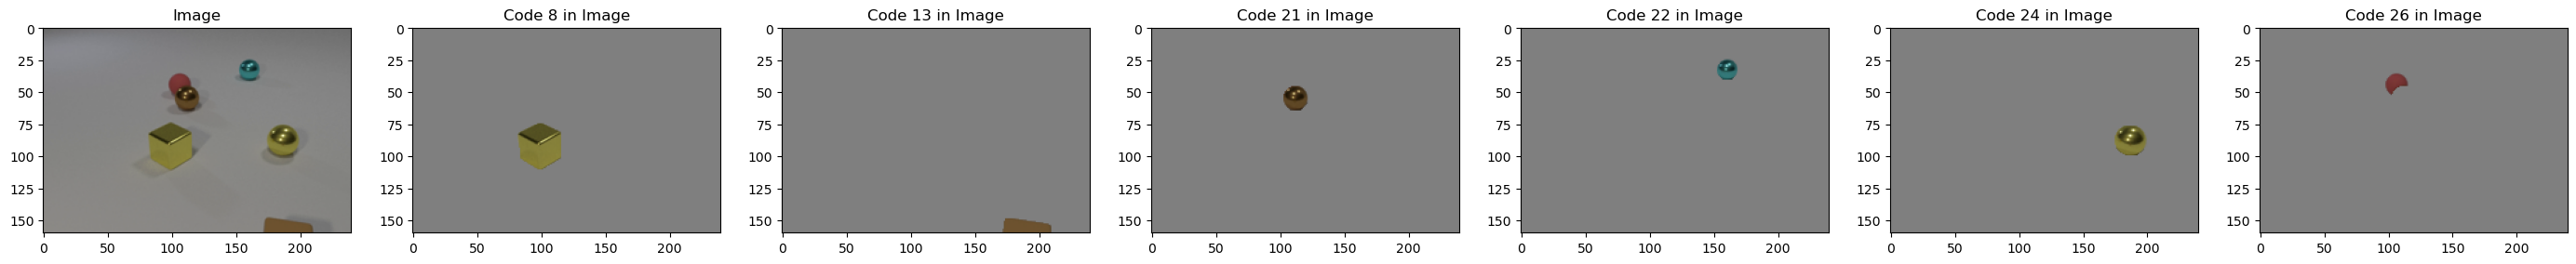

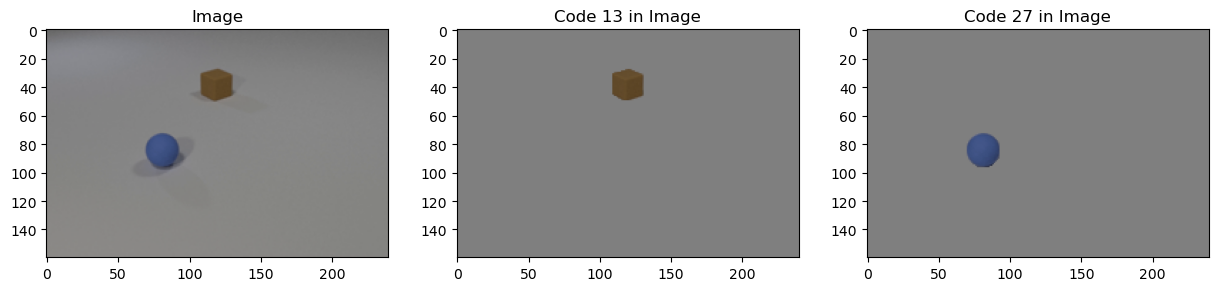

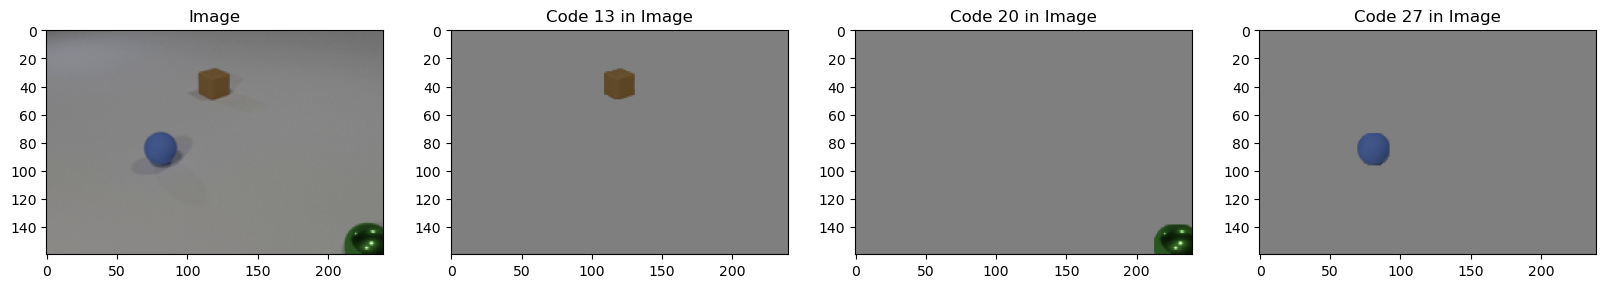

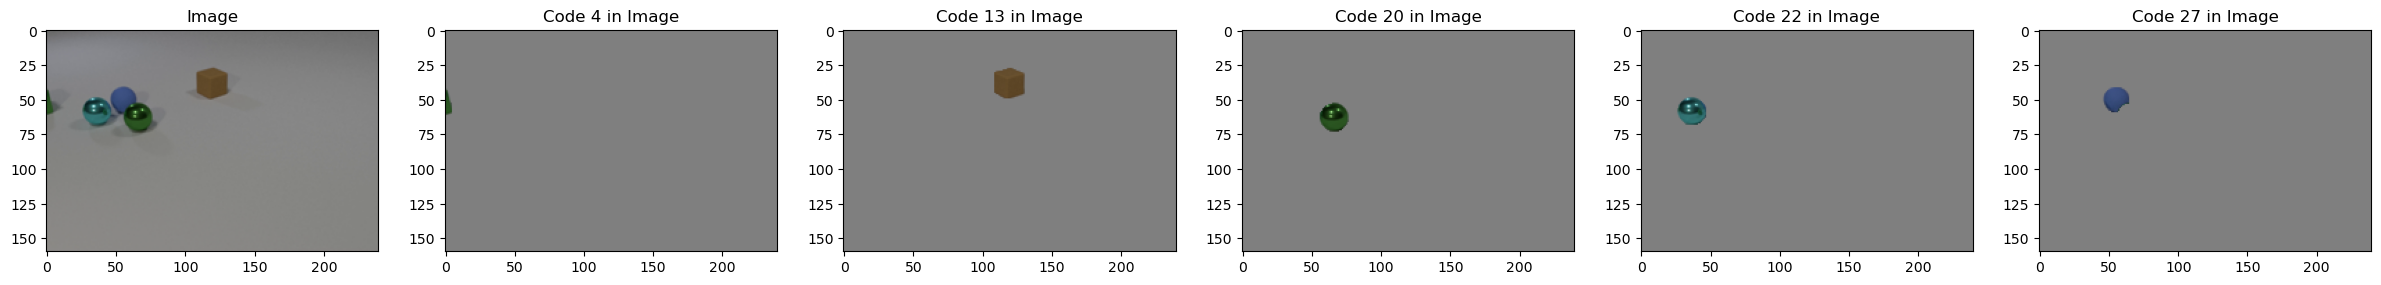

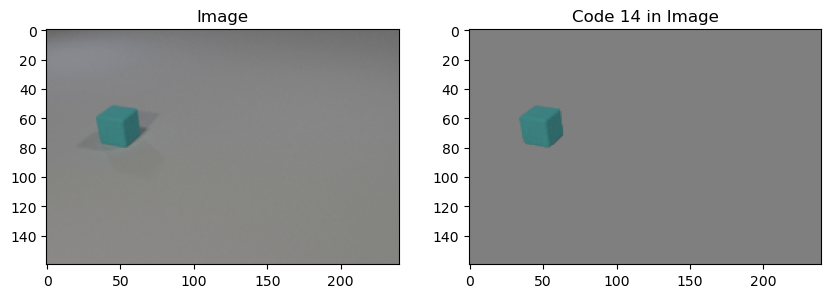

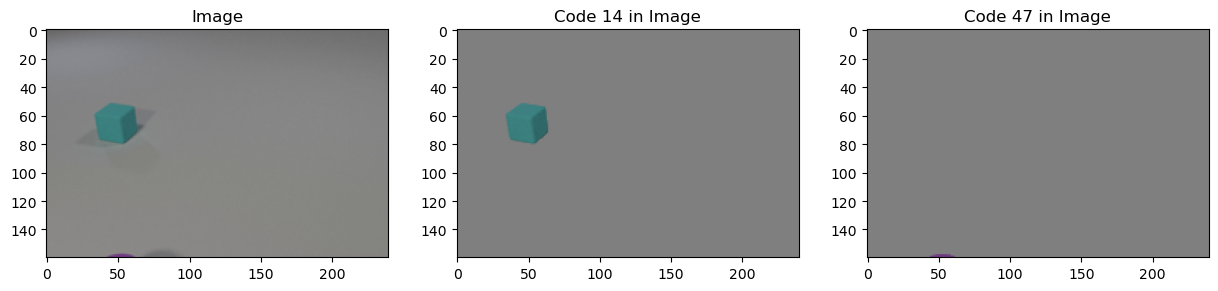

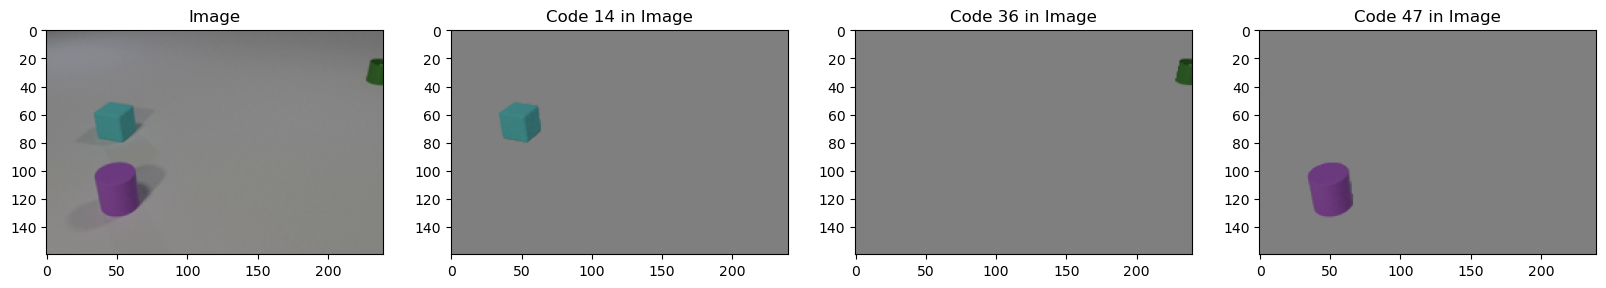

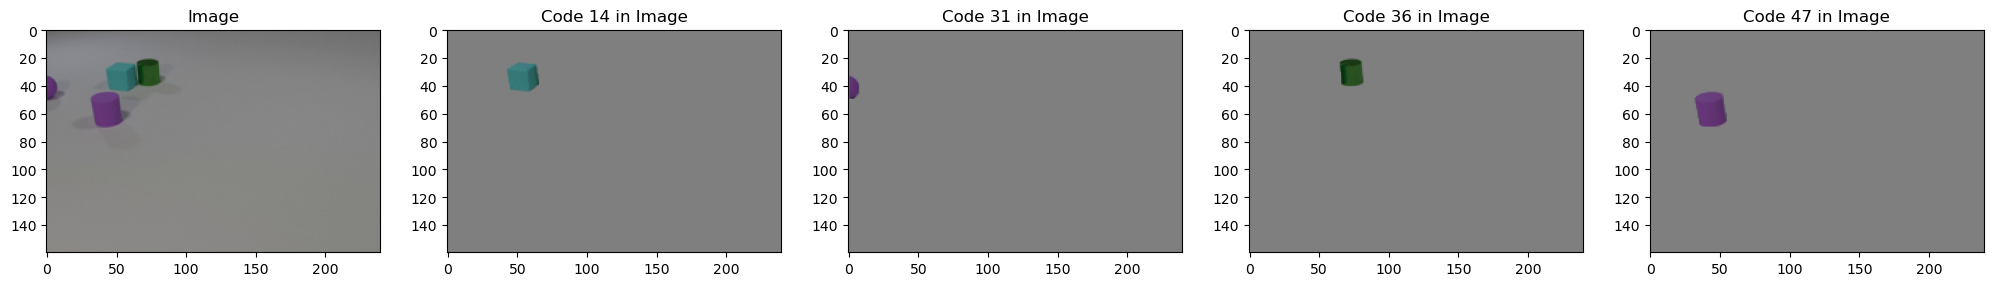

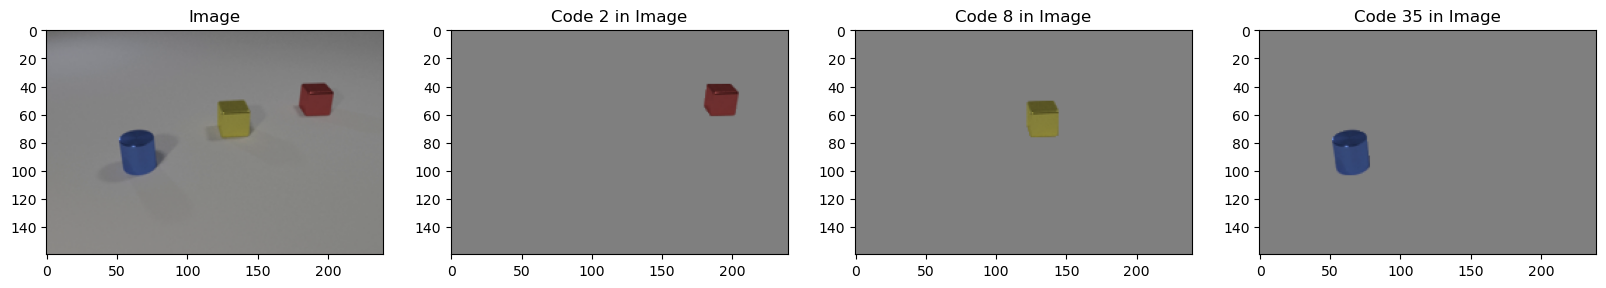

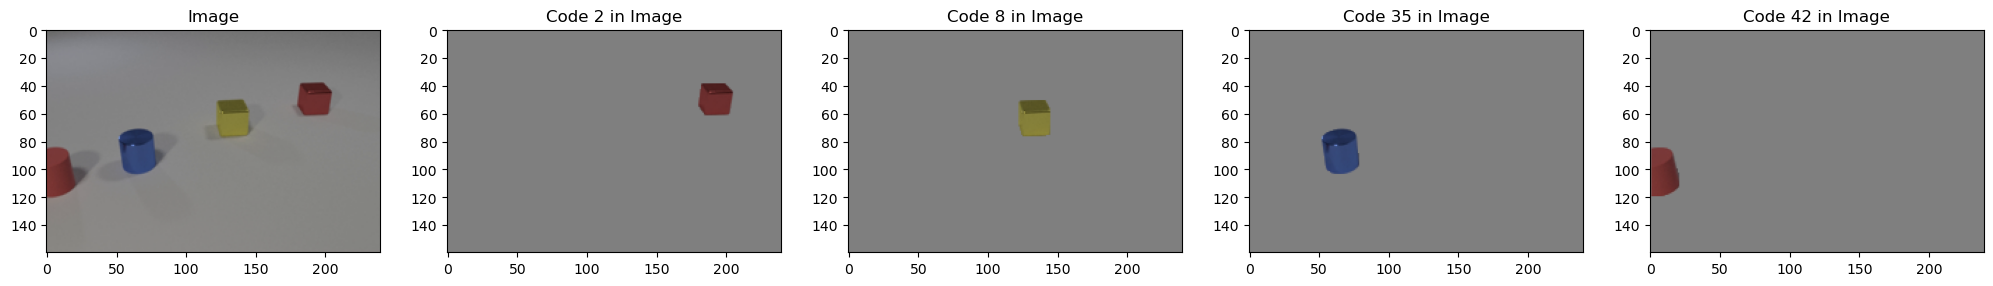

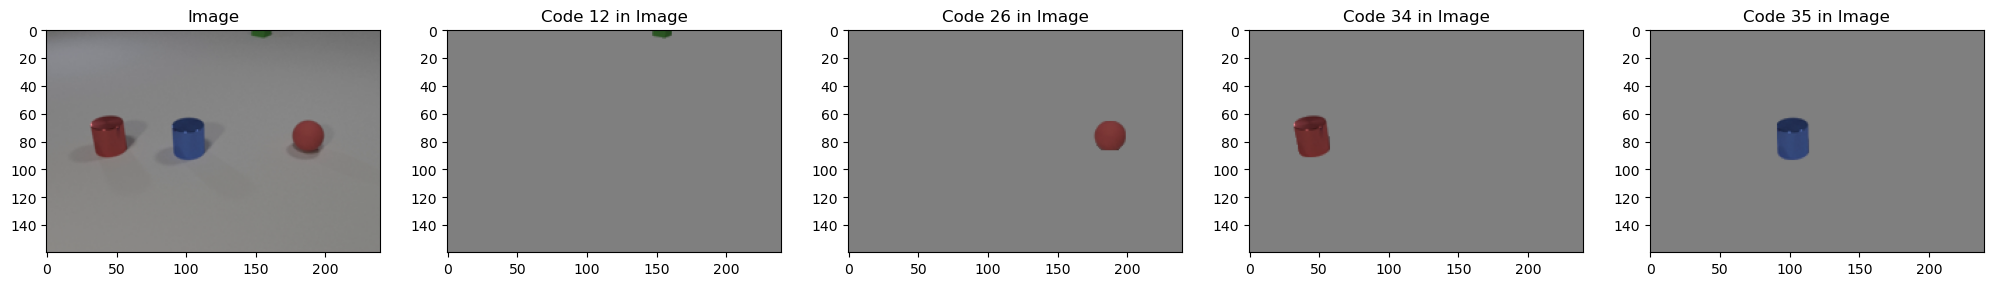

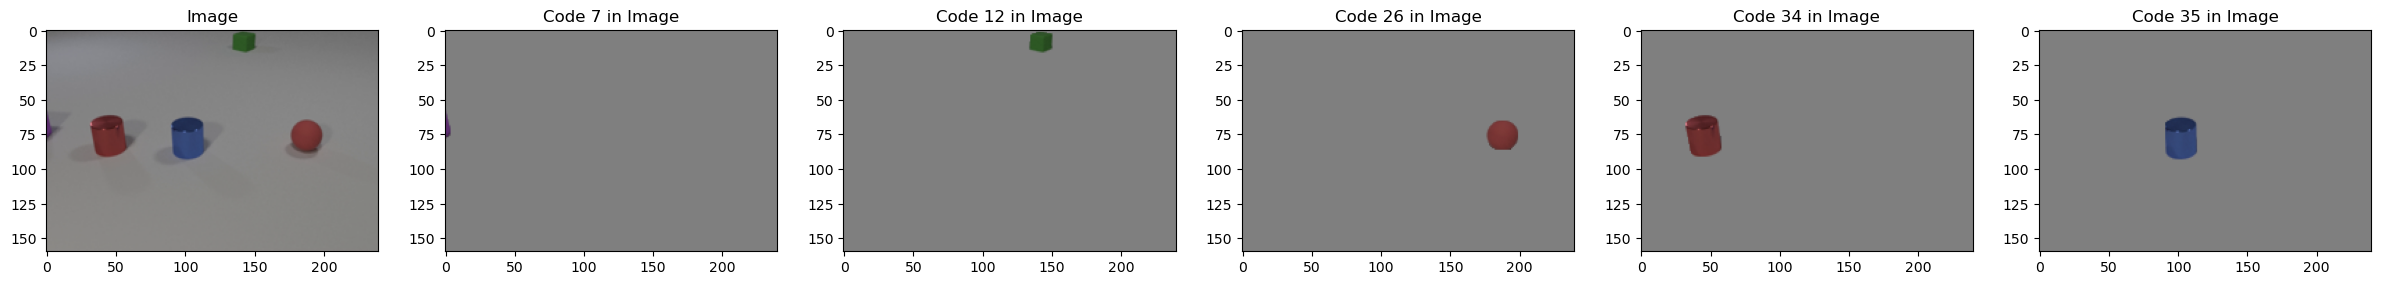

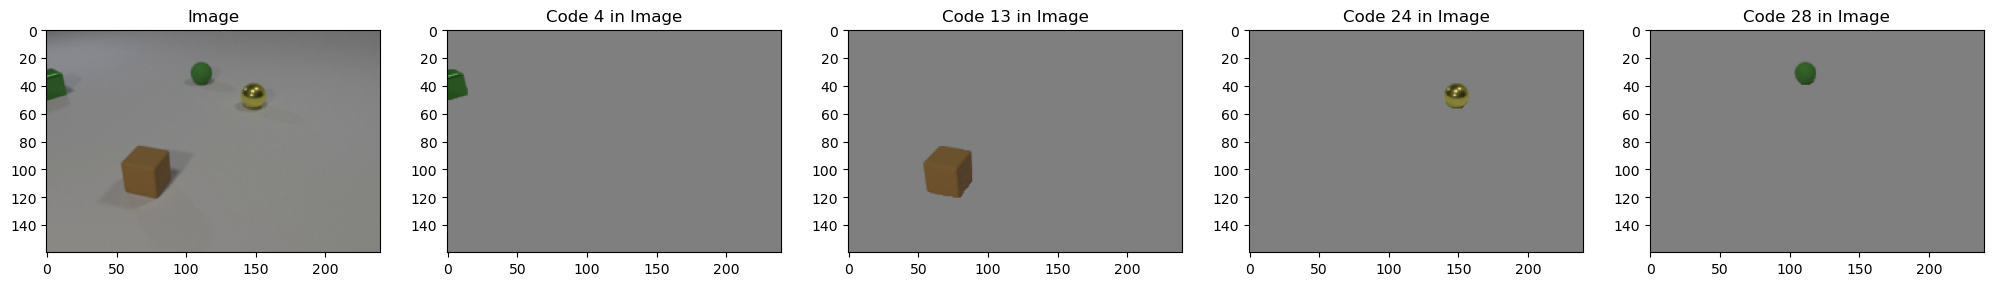

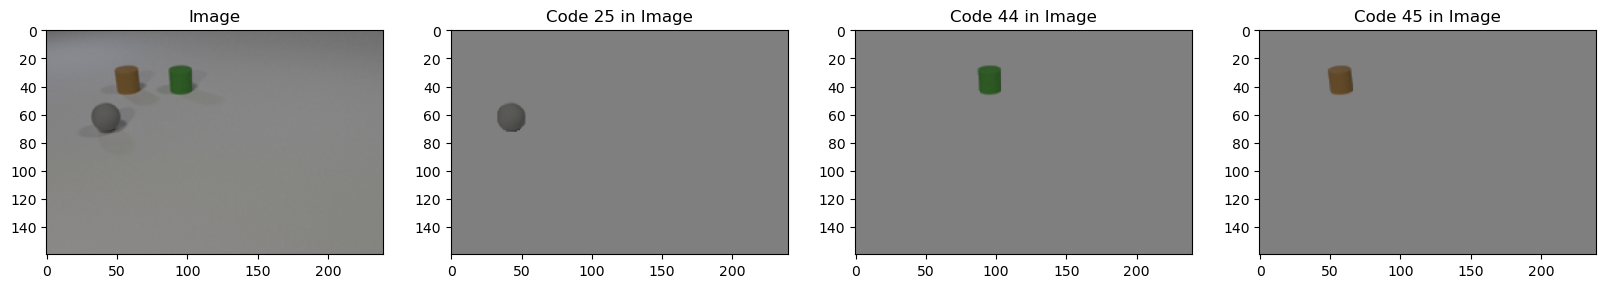

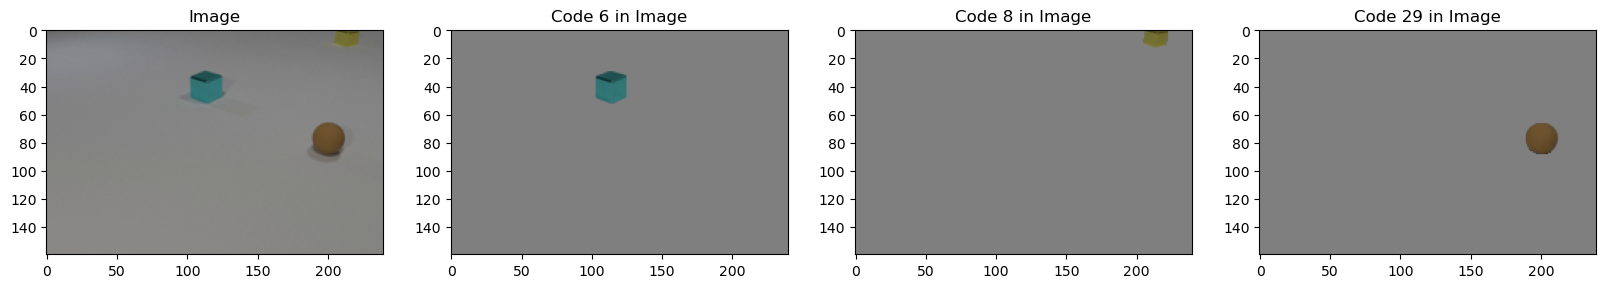

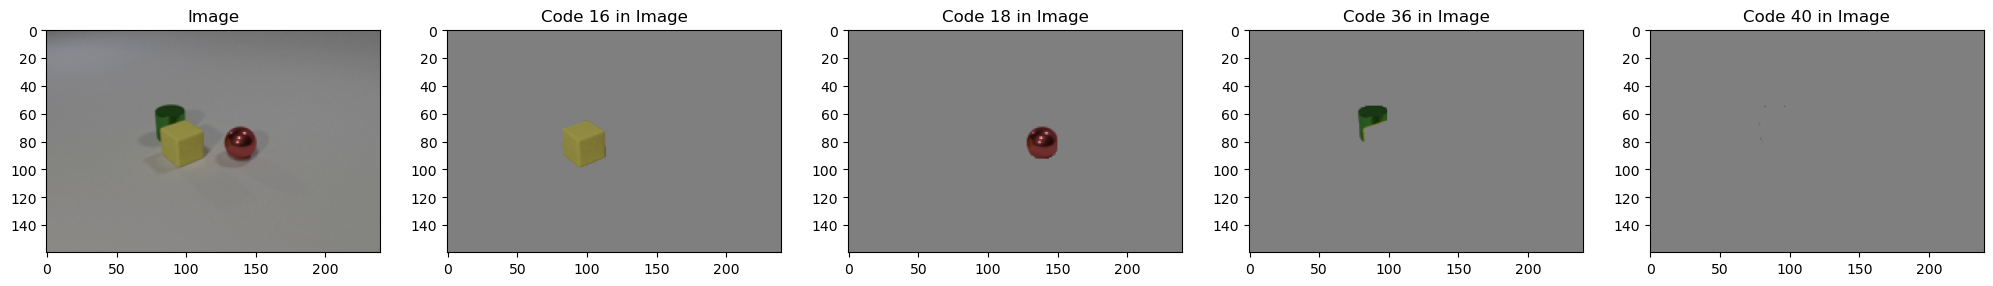

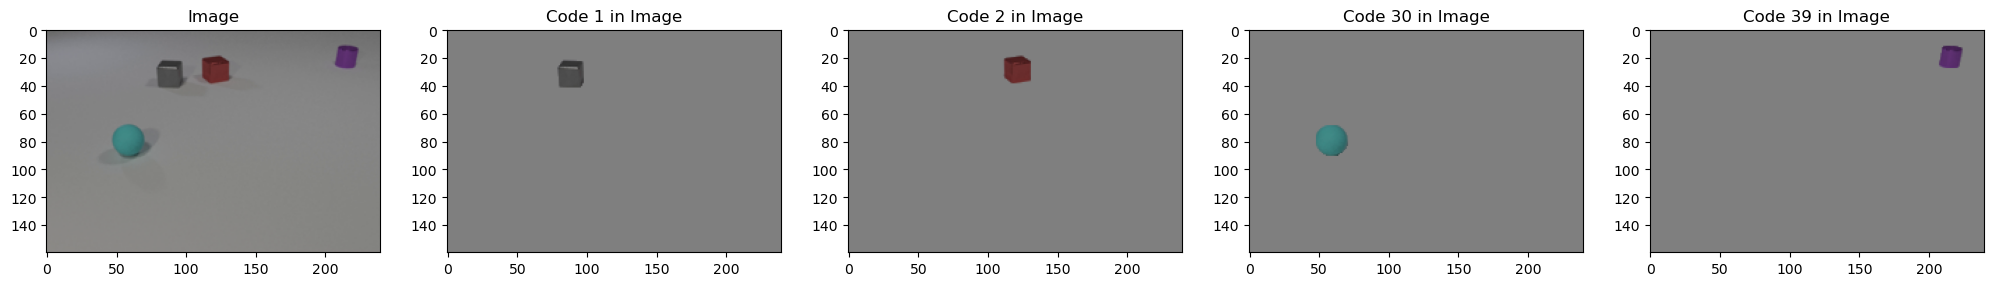

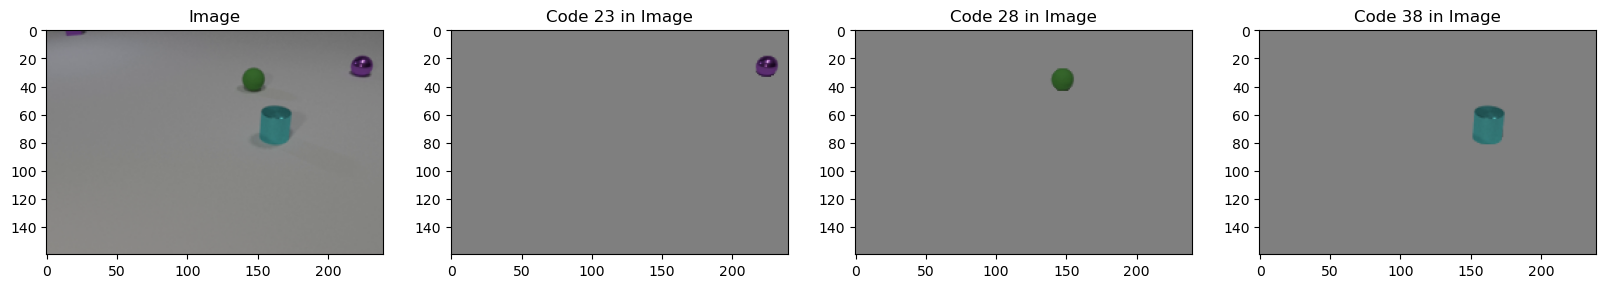

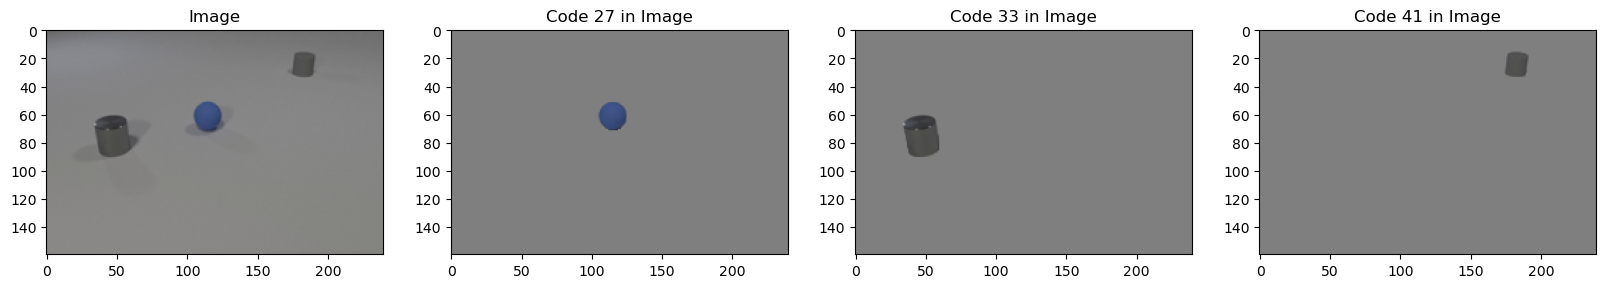

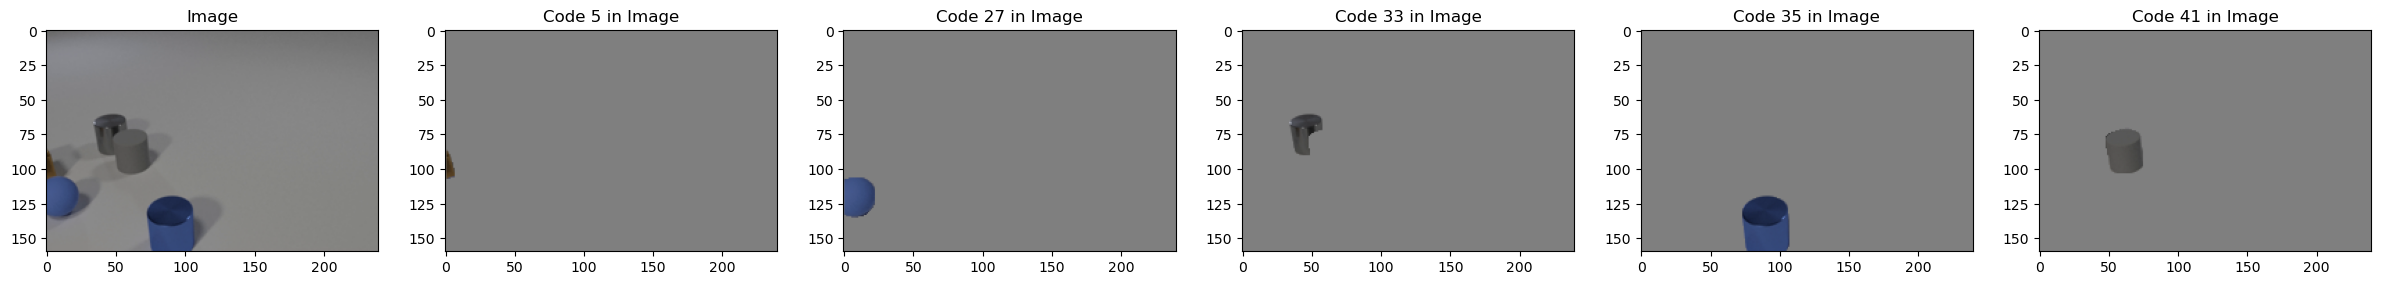

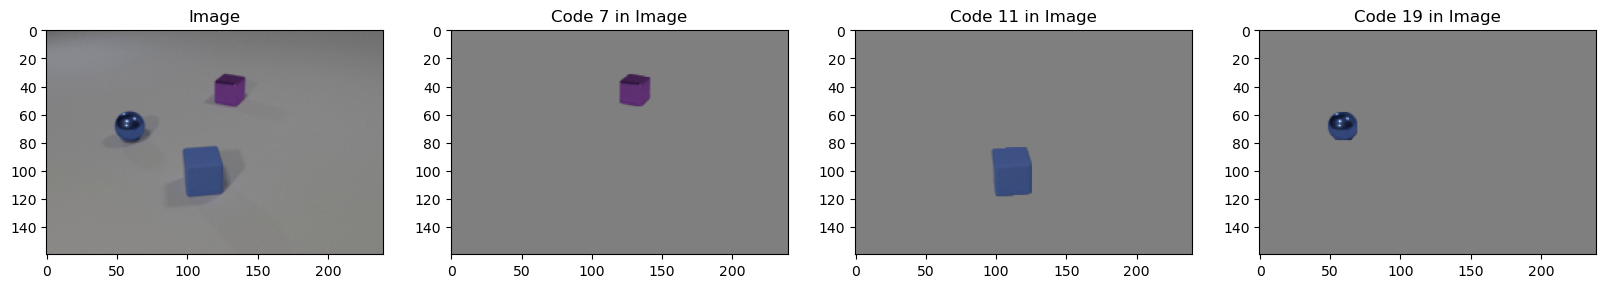

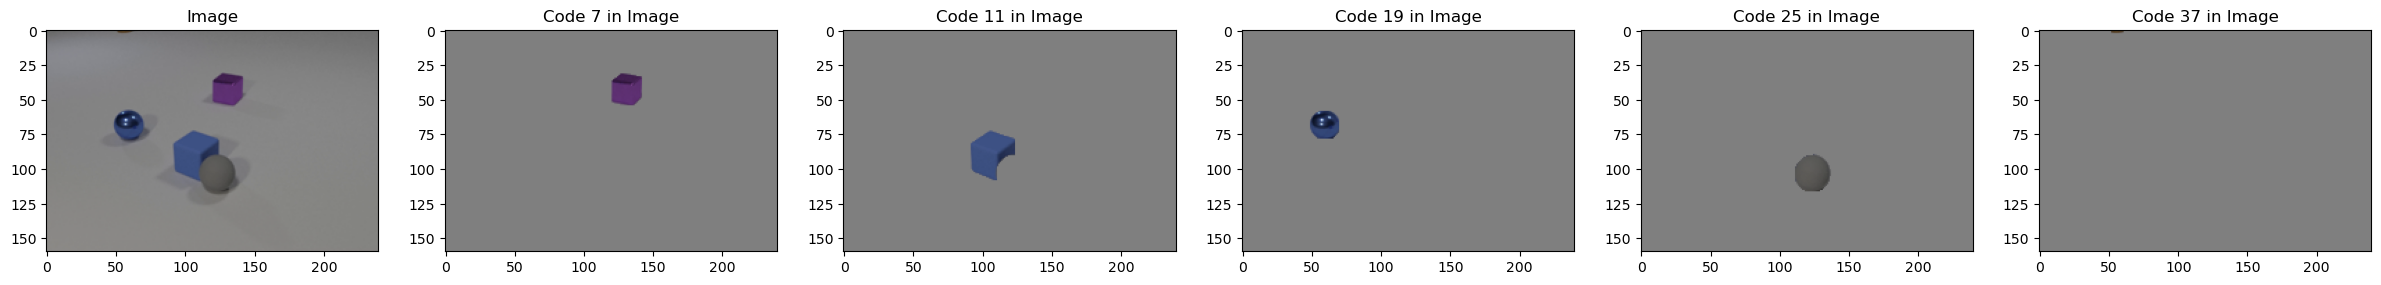

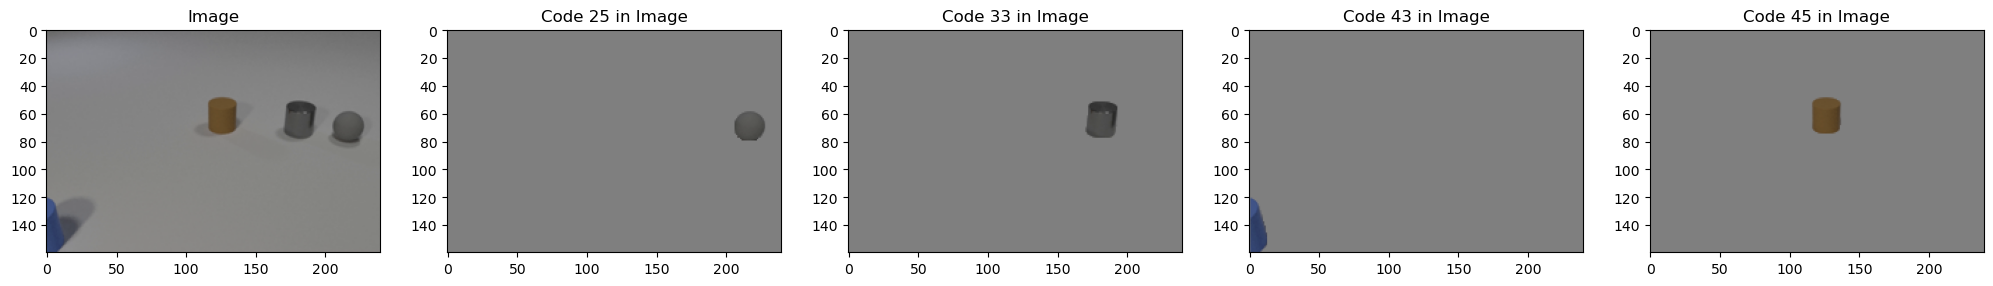

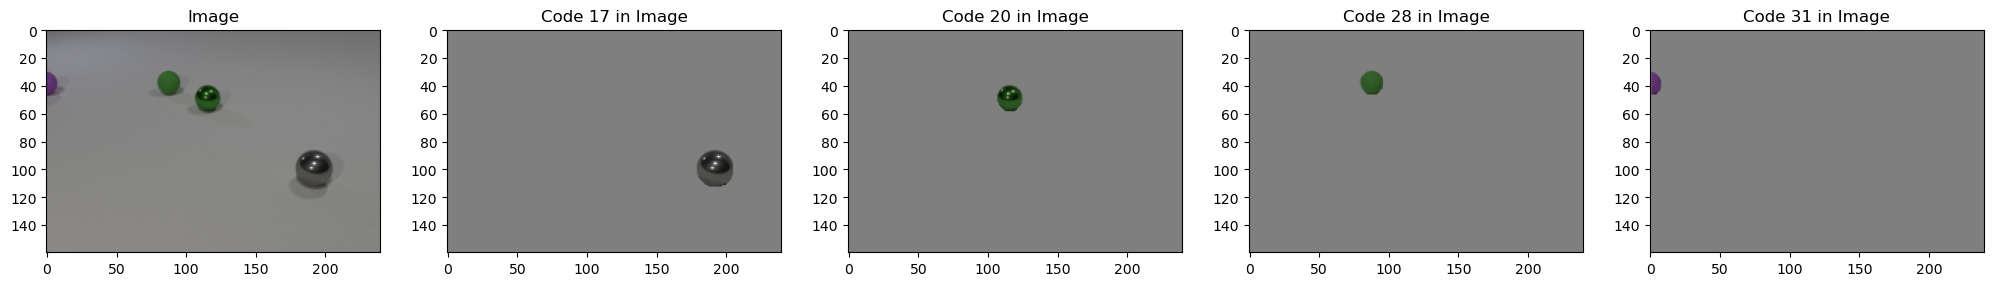

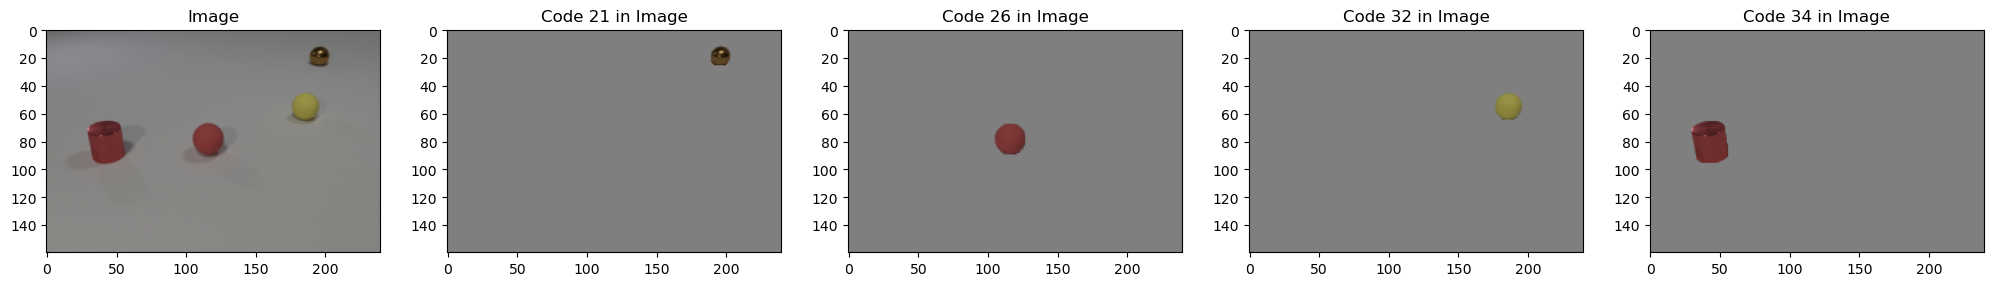

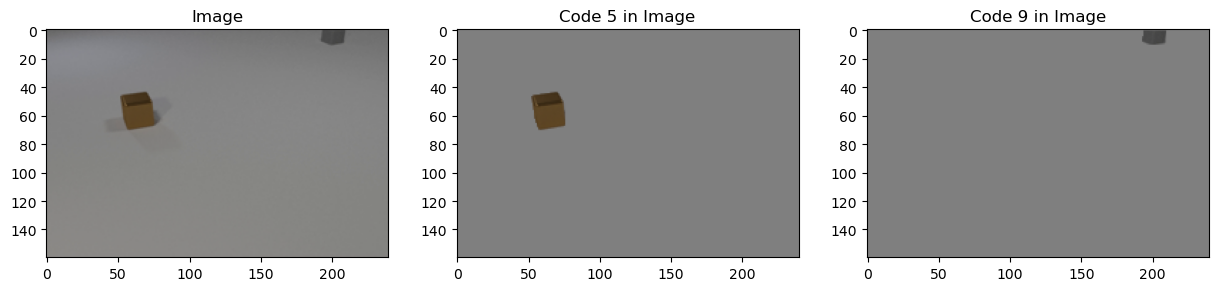

In [6]:
for image_num in range(len(unique_image_set_1)):
    visualize_batch_segments(unique_target_set_1[image_num], unique_image_set_1[image_num])